Q-Learning sử dụng Neural Network
-------------------------

In [20]:
import gym
import numpy as np
import random
import torch
import torch.nn as nn
from torch.autograd import Variable
import matplotlib.pyplot as plt

Khởi tạo các thông số cho learning

In [21]:
lr = 1e-2                                    # Learning rate
e = 0.1                                      # He so su dung cho greedly
y = 0.99                                     # gamma, he so discount reward
num_episodes = 2000                          # So game se choi
jList = []          # List chua tong so action thuc hien cua moi episode
rList = []          # List chua tong reward nhan duoc cua moi episode               

### Xây dựng **Neural Network - Function Approximation** cho **Q-Learning**
**Architecture: ** 16:4.  
**Input: **one-hot vector [16x1] mô tả state. Trong FrozenLake-v0, có 16 state tương ứng 16 vị trí agent có thể tới.  
**Output:** vector [4x1] đại diện cho **Q(s,a)** a = $\overline{1..4}$ tương ứng với 4 action: up,down,left,right.  
**Weight Initialization:** Khởi tạo trong khoảng (0,0.01), do Q(s,a) < 1.  
**Activation Function, Bias:** None.  
**Loss:** MSE  
**Optimization: **Adam.  

In [22]:
model = nn.Linear(16,4,bias=False)                      # Neural Network
nn.init.uniform(model.weight,0,0.01)                    # Weight initialization
loss_fn = nn.MSELoss(size_average=False)                # Mean square error
optim = torch.optim.Adam(model.parameters(),lr=lr)      # Optimization

In [23]:
env = gym.make('FrozenLake-v0')   # Tao enviroment Frozenlake-v0

Hàm lựa chọn action. Sử dụng nhiễu (noise) giúp agent có thể tiếp tục explore môi trường, không bị rơi vào local optimizer

In [24]:
def selectAction(s):
    Q = model(s)                         #Predict Q(s,s) [4x1]
    Qmax,a = Q.max(1)                    # Lấy giá trị, chỉ số lớn nhất của Q(s,a)
    a = a.data[0]                        # Tensor a -> int a
    if np.random.rand(1) < e:            # Tạo noise
        a = env.action_space.sample()    # Get a random action
    return a,Q

Training Neural Network dự đoán được giá trị **Q(s,a)** khi biết đầu vào trạng thái, reward. Hàm loss được định nghĩa như sau:  

$$loss = Q(s,a) -[r + \gamma max_a Q(s',a')] $$

Trong đó, r là reward $ \gamma $ là hệ số discount reward (y):

In [25]:
def UpdateQ(s1,r):
    Q1 = model(s1)              # Predict s1->Q(s1,a1)
    Qmax,_ = Q1.max(1)          # Chon gia tri Q(s1,a1) lon nhat
    Qmax = Qmax.data[0]         # Tensor Qmax -> float Qmax
    targetQ = Q.clone().data    # Sao chép Qtarget <- Q. Không thể dùng phép gán ở đây **
    targetQ[0][a] = r + y*Qmax  # Update Q(s,a)
    targetQ = Variable(targetQ, requires_grad=False)   # Tensor -> Variable 
    loss = loss_fn(Q, targetQ)  # tính loss
    optim.zero_grad()           # Update
    loss.backward()             # backprop
    optim.step()

Định nghĩa hàm chuyển state kiểu int sang one-hot vector

In [26]:
def int2onehot(s):
    return Variable(torch.Tensor(np.identity(16)[s:s+1]))        

## Main

In [27]:
if __name__=='__main__':
    for i in range(num_episodes):
        s = env.reset()                    # Reset enviroment, return start state
        s = int2onehot(s)
        rAll = 0
        d = False
        j = 0
        while j<100:
            a,Q = selectAction(s)          # Select action
            s1,r,d,info = env.step(a)      # executable action
            s1 = int2onehot(s1)
            UpdateQ(s1,r)                  # update Q-NNs
            s = s1                         # update state
            rAll += r                      # accumulate reward
            j += 1
            if d==True:
                e = 1.0/((i*1.0/50+10))
        jList.append(j)
        rList.append(rAll)

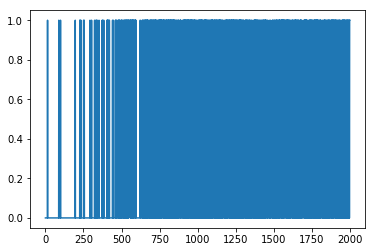

end


In [28]:
plt.plot(rList) 
plt.show()
print ('end')

Biểu đồ trên cho thấy, số episode mà agent tới được vị trí Goal tăng dần trên toàn bộ 2000 episode